## 3 Channel, Alex , Sun+Sky

In [1]:
# Math
import numpy as np
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import StepLR
# Custom
from loader import AlexNetModule, Train_Dataset, Eval_Dataset
import os
from libs.projections import bin2Sphere
from utils import getAngle

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
BATCH_SIZE = 64
EPOCHS = 500

# 하이퍼파라미터 설정
learning_rate = 0.01

In [4]:
dataset = Train_Dataset(csv_path='./mydata/trans_mode_label.csv')
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [5]:
eval_dataset = Eval_Dataset(csv_path='./mydata/trans_mode_label.csv')
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [6]:
illuminationModule = AlexNetModule().cuda()

In [7]:
from torchsummary import summary

summary(illuminationModule, input_size=(3,320,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 79, 59]          23,296
               ELU-2           [-1, 64, 79, 59]               0
         MaxPool2d-3           [-1, 64, 39, 29]               0
            Conv2d-4          [-1, 192, 39, 29]         307,392
               ELU-5          [-1, 192, 39, 29]               0
         MaxPool2d-6          [-1, 192, 19, 14]               0
            Conv2d-7          [-1, 384, 19, 14]         663,936
               ELU-8          [-1, 384, 19, 14]               0
            Conv2d-9          [-1, 256, 19, 14]         884,992
              ELU-10          [-1, 256, 19, 14]               0
           Conv2d-11          [-1, 256, 19, 14]         590,080
              ELU-12          [-1, 256, 19, 14]               0
        MaxPool2d-13            [-1, 256, 9, 6]               0
          Dropout-14                [-1

In [8]:
sun_crit = nn.KLDivLoss()
prr_crit = nn.MSELoss()
# set optimizer
optimizer = optim.Adam(illuminationModule.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [9]:
def trainloop(module, lr=0.01, train_epochs=EPOCHS):
    global total_l, sky_l, sun_l
    # set training dataset
    dataset = Train_Dataset(csv_path='./mydata/trans_mode_label.csv')
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    # using KL divergence loss for sun distribution and MSE loss  
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()
    # set optimizer
    optimizer = torch.optim.Adam(module.parameters(), lr=lr)

    # train the model
    cur_lr = lr

    for i in range(train_epochs):
        module.train()
        for i_batch, sample in enumerate(train_dataloader):
            # training input and targets
            img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()

            # forward pass 
            pred_dis, pred_prrs = module(img)
            beta = 0.1 # to compensate for the number od bins in output distribution
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            loss = sun_loss + beta * prr_loss

            # optimization
            #if i_batch % 10 == 0 :
                #print('epoch:', i+1, 'steps:', i_batch+1, "sun_loss: ", 'loss:', loss.item())
            #    print('EPOCH : %d, STEPS : %d, sun_loss : %.5f, prr_loss : %.5f, loss : %.5f'%(i+1, i_batch+1, sun_loss.item(), prr_loss.item(), loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_l.append(loss.item())
        sun_l.append(sun_loss.item())
        sky_l.append(prr_loss.item())
        
        print('='*20,'EPOCH : ', i,'='*20)
        print('-'*20,'TRAIN','-'*20)
        print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
        print('-'*20,'TEST','-'*20)
        evaluate(module, eval_dataloader, optimizer, train_epochs)
        
        # Decay learning rate (0.5/15 epochs)
        if i % 15 == 0:
            cur_lr *= 0.5
            update_lr(optimizer, cur_lr)
        

    # Save the model checkpoint
    torch.save(module.state_dict(), '17_9_alex_weights.pth')

In [10]:
test_total_l = []
test_sun_l = []
test_sky_l = []


def evaluate(module, eval_dataloader, optimizer, epoch):
    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    
    for i, sample in enumerate(eval_dataloader):
        num_of_mini_batch = len(eval_dataloader)
        input_img = sample['img'].cuda().float()
        label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
        sunpos = sample['sp'][0].numpy()

        with torch.no_grad():
            #print("="*20,i,"="*20)
            pred_dis, pred_prrs = module(input_img)
            #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
            #print("pred_dis : ", pred_dis)
            #print("pred_prrs : ", pred_prrs)
            #print(input_img)
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            beta = 0.1
            loss = sun_loss + beta * prr_loss

            sum_loss += loss.item()
#                print("sum_loss : " , sum_loss)

            # calculate all prediction error
            bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
            pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
            #print('pred_sunpos : ', pred_sunpos)
            suns.append(pred_sunpos)
            suns_gt.append(sunpos)
            sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
            angular.append(sunpos_err)
            # Sky sun kappa beta turbidity
            sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
            sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
            kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
            beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
            tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
            sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])

#            if i % 5 == 0:
#                print("({:.0f}%)   sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(100.*i / num_of_mini_batch, sun_loss.item(), prr_loss.item(), loss.item()))

    print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
    if epoch == 499:    
        print("="*20,"FINAL ERROR","="*20)
    #    print('Testing avg loss:', sum_loss/data_length)
        final_err = sum_err/data_length
    #    print('Average predictions error:')
        print('sun position (angular error):', final_err[0])
        print('sky color error :', final_err[1])
        print('sun color error:', final_err[2])
        print('kappa error :', final_err[3])
        print('beta error:', final_err[4])
        print('turbidity error:', final_err[5])

    test_total_l.append(loss.item())
    test_sun_l.append(sun_loss.item())
    test_sky_l.append(prr_loss.item())
    return suns_gt, suns, bins, angular

In [11]:
def main():

    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    Module = AlexNetModule().cuda()

    trainloop(Module)
    
total_l = []
sun_l = []
sky_l = []

if __name__ == '__main__':
    main()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


==================== EPOCH :  0 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01321,  prr_loss : 62.30076,  loss : 6.24328 
-------------------- TEST --------------------
sun_loss : 0.01734,  prr_loss : 58.00457,  loss : 5.81779 
==================== EPOCH :  1 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01330,  prr_loss : 75.12737,  loss : 7.52603 
-------------------- TEST --------------------
sun_loss : 0.01366,  prr_loss : 57.54725,  loss : 5.76838 
==================== EPOCH :  2 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01348,  prr_loss : 58.51932,  loss : 5.86541 
-------------------- TEST --------------------
sun_loss : 0.01317,  prr_loss : 56.97377,  loss : 5.71055 
==================== EPOCH :  3 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01372,  prr_loss : 69.38103,  loss : 6.95183 
-------------------- TEST ----------------

sun_loss : 0.01192,  prr_loss : 45.42172,  loss : 4.55409 
==================== EPOCH :  31 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01134,  prr_loss : 44.38644,  loss : 4.44999 
-------------------- TEST --------------------
sun_loss : 0.01200,  prr_loss : 44.84021,  loss : 4.49602 
==================== EPOCH :  32 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01157,  prr_loss : 49.10912,  loss : 4.92249 
-------------------- TEST --------------------
sun_loss : 0.01228,  prr_loss : 43.98944,  loss : 4.41122 
==================== EPOCH :  33 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01252,  prr_loss : 41.97677,  loss : 4.21020 
-------------------- TEST --------------------
sun_loss : 0.01203,  prr_loss : 46.48039,  loss : 4.66007 
==================== EPOCH :  34 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01086,  prr_loss : 50.252

sun_loss : 0.01206,  prr_loss : 41.99959,  loss : 4.21202 
==================== EPOCH :  62 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01194,  prr_loss : 36.82555,  loss : 3.69450 
-------------------- TEST --------------------
sun_loss : 0.01203,  prr_loss : 42.41372,  loss : 4.25340 
==================== EPOCH :  63 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01102,  prr_loss : 44.09735,  loss : 4.42076 
-------------------- TEST --------------------
sun_loss : 0.01196,  prr_loss : 42.99879,  loss : 4.31184 
==================== EPOCH :  64 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01206,  prr_loss : 44.88041,  loss : 4.50010 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.00218,  loss : 4.21232 
==================== EPOCH :  65 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01147,  prr_loss : 39.746

sun_loss : 0.01207,  prr_loss : 42.52036,  loss : 4.26411 
==================== EPOCH :  93 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01158,  prr_loss : 46.21245,  loss : 4.63283 
-------------------- TEST --------------------
sun_loss : 0.01213,  prr_loss : 42.77495,  loss : 4.28962 
==================== EPOCH :  94 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01129,  prr_loss : 52.61980,  loss : 5.27327 
-------------------- TEST --------------------
sun_loss : 0.01208,  prr_loss : 42.40462,  loss : 4.25255 
==================== EPOCH :  95 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01145,  prr_loss : 48.53022,  loss : 4.86447 
-------------------- TEST --------------------
sun_loss : 0.01209,  prr_loss : 42.54237,  loss : 4.26633 
==================== EPOCH :  96 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01170,  prr_loss : 53.016

sun_loss : 0.01210,  prr_loss : 42.36126,  loss : 4.24823 
==================== EPOCH :  124 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01110,  prr_loss : 54.64508,  loss : 5.47561 
-------------------- TEST --------------------
sun_loss : 0.01208,  prr_loss : 42.36467,  loss : 4.24855 
==================== EPOCH :  125 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01144,  prr_loss : 43.54514,  loss : 4.36595 
-------------------- TEST --------------------
sun_loss : 0.01209,  prr_loss : 42.36771,  loss : 4.24886 
==================== EPOCH :  126 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01179,  prr_loss : 40.27244,  loss : 4.03904 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.36701,  loss : 4.24880 
==================== EPOCH :  127 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01146,  prr_loss : 40

sun_loss : 0.01210,  prr_loss : 42.10474,  loss : 4.22258 
==================== EPOCH :  155 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01124,  prr_loss : 41.70162,  loss : 4.18140 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.09695,  loss : 4.22179 
==================== EPOCH :  156 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01128,  prr_loss : 39.61109,  loss : 3.97238 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.03953,  loss : 4.21606 
==================== EPOCH :  157 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01069,  prr_loss : 50.22627,  loss : 5.03332 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.38122,  loss : 4.25022 
==================== EPOCH :  158 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01160,  prr_loss : 47

sun_loss : 0.01211,  prr_loss : 42.30395,  loss : 4.24250 
==================== EPOCH :  186 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01211,  prr_loss : 48.60003,  loss : 4.87212 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.33324,  loss : 4.24544 
==================== EPOCH :  187 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01147,  prr_loss : 49.14458,  loss : 4.92592 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.40282,  loss : 4.25239 
==================== EPOCH :  188 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01185,  prr_loss : 47.62933,  loss : 4.77478 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.39049,  loss : 4.25116 
==================== EPOCH :  189 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01181,  prr_loss : 46

sun_loss : 0.01211,  prr_loss : 42.17928,  loss : 4.23003 
==================== EPOCH :  217 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01185,  prr_loss : 46.46164,  loss : 4.65802 
-------------------- TEST --------------------
sun_loss : 0.01209,  prr_loss : 42.26851,  loss : 4.23895 
==================== EPOCH :  218 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01151,  prr_loss : 47.86449,  loss : 4.79796 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.35878,  loss : 4.24799 
==================== EPOCH :  219 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01141,  prr_loss : 47.76585,  loss : 4.78799 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.42131,  loss : 4.25424 
==================== EPOCH :  220 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01169,  prr_loss : 48

sun_loss : 0.01211,  prr_loss : 42.40817,  loss : 4.25293 
==================== EPOCH :  248 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01185,  prr_loss : 48.46239,  loss : 4.85809 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.27018,  loss : 4.23912 
==================== EPOCH :  249 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01135,  prr_loss : 47.33506,  loss : 4.74486 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.33226,  loss : 4.24533 
==================== EPOCH :  250 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01190,  prr_loss : 54.64104,  loss : 5.47600 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.29810,  loss : 4.24192 
==================== EPOCH :  251 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01085,  prr_loss : 43

sun_loss : 0.01212,  prr_loss : 42.24498,  loss : 4.23662 
==================== EPOCH :  279 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01128,  prr_loss : 37.25446,  loss : 3.73673 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.18043,  loss : 4.23015 
==================== EPOCH :  280 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01189,  prr_loss : 44.63506,  loss : 4.47539 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.22197,  loss : 4.23430 
==================== EPOCH :  281 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01127,  prr_loss : 45.67250,  loss : 4.57852 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.35188,  loss : 4.24729 
==================== EPOCH :  282 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01188,  prr_loss : 50

sun_loss : 0.01209,  prr_loss : 42.28700,  loss : 4.24079 
==================== EPOCH :  310 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01165,  prr_loss : 43.43369,  loss : 4.35502 
-------------------- TEST --------------------
sun_loss : 0.01212,  prr_loss : 42.11300,  loss : 4.22342 
==================== EPOCH :  311 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01206,  prr_loss : 55.45993,  loss : 5.55805 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.28359,  loss : 4.24046 
==================== EPOCH :  312 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01149,  prr_loss : 44.94434,  loss : 4.50592 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.30775,  loss : 4.24288 
==================== EPOCH :  313 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01079,  prr_loss : 39

sun_loss : 0.01211,  prr_loss : 42.30692,  loss : 4.24280 
==================== EPOCH :  341 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01178,  prr_loss : 52.96014,  loss : 5.30779 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.30542,  loss : 4.24264 
==================== EPOCH :  342 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01151,  prr_loss : 46.27095,  loss : 4.63861 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.30714,  loss : 4.24282 
==================== EPOCH :  343 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01136,  prr_loss : 47.47638,  loss : 4.75900 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.27677,  loss : 4.23978 
==================== EPOCH :  344 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01172,  prr_loss : 38

sun_loss : 0.01211,  prr_loss : 42.33949,  loss : 4.24606 
==================== EPOCH :  372 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01178,  prr_loss : 46.82373,  loss : 4.69415 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.42609,  loss : 4.25472 
==================== EPOCH :  373 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01175,  prr_loss : 41.98975,  loss : 4.21073 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.25169,  loss : 4.23728 
==================== EPOCH :  374 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01178,  prr_loss : 43.96561,  loss : 4.40835 
-------------------- TEST --------------------
sun_loss : 0.01212,  prr_loss : 42.17448,  loss : 4.22957 
==================== EPOCH :  375 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01094,  prr_loss : 45

sun_loss : 0.01211,  prr_loss : 42.21474,  loss : 4.23358 
==================== EPOCH :  403 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01146,  prr_loss : 52.51699,  loss : 5.26316 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.27158,  loss : 4.23926 
==================== EPOCH :  404 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01168,  prr_loss : 40.88608,  loss : 4.10029 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.21914,  loss : 4.23402 
==================== EPOCH :  405 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01132,  prr_loss : 56.61845,  loss : 5.67317 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.44794,  loss : 4.25690 
==================== EPOCH :  406 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01119,  prr_loss : 44

sun_loss : 0.01212,  prr_loss : 42.34192,  loss : 4.24631 
==================== EPOCH :  434 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01181,  prr_loss : 45.86804,  loss : 4.59861 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.24743,  loss : 4.23685 
==================== EPOCH :  435 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01136,  prr_loss : 48.36957,  loss : 4.84831 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.32316,  loss : 4.24443 
==================== EPOCH :  436 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01151,  prr_loss : 54.56473,  loss : 5.46798 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.34210,  loss : 4.24632 
==================== EPOCH :  437 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01163,  prr_loss : 50

sun_loss : 0.01211,  prr_loss : 42.17088,  loss : 4.22920 
==================== EPOCH :  465 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01165,  prr_loss : 43.61746,  loss : 4.37340 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.19864,  loss : 4.23198 
==================== EPOCH :  466 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01128,  prr_loss : 42.91215,  loss : 4.30250 
-------------------- TEST --------------------
sun_loss : 0.01211,  prr_loss : 42.18396,  loss : 4.23050 
==================== EPOCH :  467 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01119,  prr_loss : 45.96984,  loss : 4.60817 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.18244,  loss : 4.23035 
==================== EPOCH :  468 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01121,  prr_loss : 42

sun_loss : 0.01210,  prr_loss : 42.34510,  loss : 4.24661 
==================== EPOCH :  496 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01162,  prr_loss : 49.08619,  loss : 4.92024 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.32854,  loss : 4.24495 
==================== EPOCH :  497 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01139,  prr_loss : 49.32909,  loss : 4.94430 
-------------------- TEST --------------------
sun_loss : 0.01210,  prr_loss : 42.33219,  loss : 4.24532 
==================== EPOCH :  498 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01186,  prr_loss : 43.12092,  loss : 4.32395 
-------------------- TEST --------------------
sun_loss : 0.01209,  prr_loss : 42.23428,  loss : 4.23552 
==================== EPOCH :  499 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01181,  prr_loss : 44

In [12]:
print(total_l)

[6.243282318115234, 7.526032447814941, 5.865410804748535, 6.951825141906738, 6.454939842224121, 5.408474922180176, 6.555814266204834, 5.529114246368408, 6.155129432678223, 5.57230806350708, 5.81548547744751, 6.136336326599121, 5.420247554779053, 6.574981212615967, 5.6597442626953125, 5.004886150360107, 5.038931846618652, 5.450760841369629, 5.272202491760254, 6.276490688323975, 5.382439136505127, 4.297306537628174, 5.923673152923584, 5.135733127593994, 6.622233867645264, 4.772136688232422, 4.509207248687744, 5.713201999664307, 4.5600810050964355, 4.545104026794434, 4.850245952606201, 4.449985504150391, 4.9224853515625, 4.210199356079102, 5.036081314086914, 5.865334510803223, 4.613509654998779, 4.478770732879639, 4.815960884094238, 5.418839931488037, 4.659433841705322, 5.140060901641846, 5.229537010192871, 4.38902473449707, 5.234683513641357, 4.399576663970947, 4.790701866149902, 4.142521381378174, 4.604842185974121, 4.7498250007629395, 4.58430814743042, 4.932119846343994, 5.297879219055

In [13]:
print(sky_l)

[62.300758361816406, 75.12736511230469, 58.519317626953125, 69.38102722167969, 64.41593933105469, 53.95831298828125, 65.43783569335938, 55.165283203125, 61.42986297607422, 55.59899139404297, 58.033782958984375, 61.242740631103516, 54.0809211730957, 65.62787628173828, 56.47832107543945, 49.93111801147461, 50.27539825439453, 54.38823699951172, 52.60700225830078, 62.64672088623047, 53.70703125, 42.857967376708984, 59.11581039428711, 51.23640823364258, 66.11040496826172, 47.6031494140625, 44.974266052246094, 57.01768112182617, 45.4874153137207, 45.33361053466797, 48.394344329833984, 44.38644027709961, 49.10912322998047, 41.976768493652344, 50.25221252441406, 58.53932189941406, 46.0190315246582, 44.673667907714844, 48.0501594543457, 54.06814956665039, 46.47653579711914, 51.2864875793457, 52.176692962646484, 43.775367736816406, 52.22615051269531, 43.87839889526367, 47.79669189453125, 41.30353546142578, 45.935081481933594, 47.38452911376953, 45.729454040527344, 49.208251953125, 52.86530303955

In [14]:
print(sun_l)

[0.013206657953560352, 0.013295672833919525, 0.013478752225637436, 0.013722234405577183, 0.013345558196306229, 0.012643561698496342, 0.012030377052724361, 0.012585746124386787, 0.012143145315349102, 0.012408840470016003, 0.012106725946068764, 0.012062118388712406, 0.012155711650848389, 0.012193603441119194, 0.011911922134459019, 0.011774016544222832, 0.011392020620405674, 0.011937250383198261, 0.01150236465036869, 0.011818400584161282, 0.01173597201704979, 0.01150988694280386, 0.012092214077711105, 0.012092058546841145, 0.011193129234015942, 0.01182169932872057, 0.011780571192502975, 0.011433391831815243, 0.011339271441102028, 0.011743138544261456, 0.010811368003487587, 0.011341559700667858, 0.011572788469493389, 0.012522358447313309, 0.010859731584787369, 0.011402060277760029, 0.011606352403759956, 0.011404145509004593, 0.010944950394332409, 0.012024953030049801, 0.01178009994328022, 0.011412045918405056, 0.011867615394294262, 0.011487739160656929, 0.012068078853189945, 0.011736718006

In [15]:
print(test_total_l)

[5.8177947998046875, 5.768381118774414, 5.710550308227539, 5.627718925476074, 5.503683567047119, 5.465224266052246, 5.391984939575195, 5.341580390930176, 5.400580406188965, 5.168465614318848, 5.153981685638428, 5.081827163696289, 5.002021789550781, 4.996274948120117, 4.852161884307861, 4.851527214050293, 4.960355281829834, 4.867621898651123, 4.811412334442139, 4.909597396850586, 4.868699550628662, 4.710719108581543, 4.659531593322754, 4.7467756271362305, 4.937658786773682, 4.587304592132568, 4.583507061004639, 4.8988566398620605, 4.476907730102539, 4.577906131744385, 4.554091930389404, 4.496020317077637, 4.4112229347229, 4.660065650939941, 4.32762336730957, 4.435366630554199, 4.5727057456970215, 4.596510410308838, 4.485769748687744, 4.5091729164123535, 4.465822219848633, 4.3593430519104, 4.233990669250488, 4.386053562164307, 4.659309387207031, 4.407116889953613, 4.425706386566162, 4.438088893890381, 4.215224266052246, 4.471617221832275, 4.425929069519043, 4.377181529998779, 4.233582973

In [16]:
print(test_sky_l)

[58.00457000732422, 57.54724884033203, 56.97377014160156, 56.14484405517578, 54.90885925292969, 54.52579879760742, 53.79484939575195, 53.29068374633789, 53.880165100097656, 51.56120300292969, 51.417633056640625, 50.69623947143555, 49.89778137207031, 49.84208297729492, 48.40055847167969, 48.393428802490234, 49.482357025146484, 48.55601501464844, 47.993038177490234, 48.975982666015625, 48.56700134277344, 46.986846923828125, 46.473365783691406, 47.34785842895508, 49.25546646118164, 45.7542724609375, 45.71495056152344, 48.86792755126953, 44.64703369140625, 45.65883255004883, 45.42171859741211, 44.840206146240234, 43.989437103271484, 46.48039245605469, 43.15495681762695, 44.23384475708008, 45.6062126159668, 45.84574890136719, 44.73716735839844, 44.97216033935547, 44.53982925415039, 43.47216796875, 42.22040939331055, 43.73941421508789, 46.46773147583008, 43.9504508972168, 44.13578796386719, 44.26030731201172, 42.03089141845703, 44.59644317626953, 44.13912582397461, 43.65176773071289, 42.2152

In [17]:
print(test_sun_l)

[0.017337936908006668, 0.013656141236424446, 0.013173033483326435, 0.013234419748187065, 0.012797580100595951, 0.012644482776522636, 0.012499903328716755, 0.012511941604316235, 0.012563647702336311, 0.01234531681984663, 0.01221841387450695, 0.012203235179185867, 0.012243651784956455, 0.012066405266523361, 0.012106092646718025, 0.012184342369437218, 0.012119222432374954, 0.01201996672898531, 0.012108398601412773, 0.011999290436506271, 0.011998908594250679, 0.012034652754664421, 0.012195179238915443, 0.011989776045084, 0.012112021446228027, 0.011876975186169147, 0.01201197225600481, 0.012063870206475258, 0.012204207479953766, 0.012022829614579678, 0.011920133605599403, 0.011999514885246754, 0.012278914451599121, 0.012026350945234299, 0.012127324007451534, 0.011981973424553871, 0.01208470854908228, 0.011935397051274776, 0.01205279491841793, 0.011956547386944294, 0.011839608661830425, 0.012125799432396889, 0.011949392966926098, 0.01211234088987112, 0.012536043301224709, 0.01207160390913486

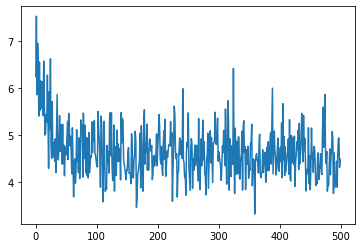

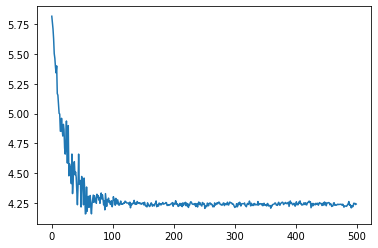

In [19]:
import matplotlib.pyplot as plt
plt.plot(total_l)
plt.show()

plt.plot(test_total_l)
plt.show()

In [4]:
import argparse
import progressbar
def evaluate(module):
    # loss function
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()

    # data loader
    eval_dataset = Eval_Dataset(csv_path='./mydata/trans_mode_label.csv')
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4)
    print(eval_dataloader)

    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    with progressbar.ProgressBar(max_value=data_length) as bar:
        for i, sample in enumerate(eval_dataloader):
            input_img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
            sunpos = sample['sp'][0].numpy()

            with torch.no_grad():
                #print("="*20,i,"="*20)
                pred_dis, pred_prrs = module(input_img)
                #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
                #print("pred_dis : ", pred_dis)
                #print("pred_prrs : ", pred_prrs)
                #print(input_img)
                sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
                beta = 0.1
                loss = sun_loss + beta * prr_loss
                sum_loss += loss.item()
                
                # calculate all prediction error
                bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
                pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
                #print('pred_sunpos : ', pred_sunpos)
                suns.append(pred_sunpos)
                suns_gt.append(sunpos)
                sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
                angular.append(sunpos_err)
                # Sky sun kappa beta turbidity
                sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
                sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
                kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
                beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
                tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
                sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])
            bar.update(i)
    # print average prediction errors across all testing dataset
    print("="*20,"FINAL ERROR","="*20)
    print('Testing avg loss:', sum_loss/data_length)
    final_err = sum_err/data_length
    print('Average predictions error:')
    print('sun position (angular error):', final_err[0])
    print('sky color error :', final_err[1])
    print('sun color error:', final_err[2])
    print('kappa error :', final_err[3])
    print('beta error:', final_err[4])
    print('turbidity error:', final_err[5])
    return suns_gt, suns, bins, angular

In [5]:
def main(args):
    print('loading weights ...')
    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    module = AlexNetModule().cuda()
    #load pre-trained weight
    module.load_state_dict(torch.load(args.pre_trained))

    print('start evaluating ...')
    suns_gt, suns, bins, angular= evaluate(module)
    print('evaluation done!')
    return suns_gt, suns, bins, angular

In [6]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
  
    parser.add_argument('--pre_trained', default='./17_9_alex_weights.pth', help='pre-trained weight path')
    
    args = parser.parse_args(args=[])
    
    suns_gt, suns, bins, angular = main(args)

loading weights ...
start evaluating ...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100% (446 of 446) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


==================== FINAL ERROR ====================
Testing avg loss: 4.604468725989218
Average predictions error:
sun position (angular error): 68.91516590232527
sky color error : 0.21398530499550258
sun color error: 1.1615402608850947
kappa error : 0.06194791707289593
beta error: 9.42836141800132
turbidity error: 16.26981104222114
evaluation done!


In [7]:
print(angular)

[66.88287382148643, 77.78828610659875, 5.531638245335527, 5.531638245335527, 61.86868589094227, 92.2854915754442, 5.488799463466992, 105.3626864569204, 124.20063066716367, 10.053934863769253, 10.053934863769253, 38.850589084999285, 38.850589084999285, 48.54590728788835, 0.6397194580565669, 120.5954046897809, 133.85403070290545, 22.248234660989677, 96.78525669313113, 57.058629007684644, 70.97961643293455, 84.3873563561804, 31.606666779075017, 17.883482758579458, 113.3437984028522, 96.7991072750542, 96.7991072750542, 96.7991072750542, 96.7991072750542, 96.7991072750542, 100.6818042153449, 108.82771272894554, 108.82771272894554, 21.795448384722505, 40.849312657149625, 1.768955336561102, 41.995415653483, 111.6964971689143, 41.26660846211079, 28.236059175824394, 98.09923708313627, 113.12541428429353, 27.080251782235724, 4.272554516422548, 35.56735142101579, 7.098181373435189, 7.098181373435189, 39.70671965985151, 39.70671965985151, 26.533845404379182, 92.2360080900699, 35.13930238036529, 11